# ta-lib-003 ( EMA RSI MACD)
https://chatgpt.com/c/6807cac1-343c-800a-98b6-8628301f5e26

✅ Indicators added and saved to forex_with_indicators.csv


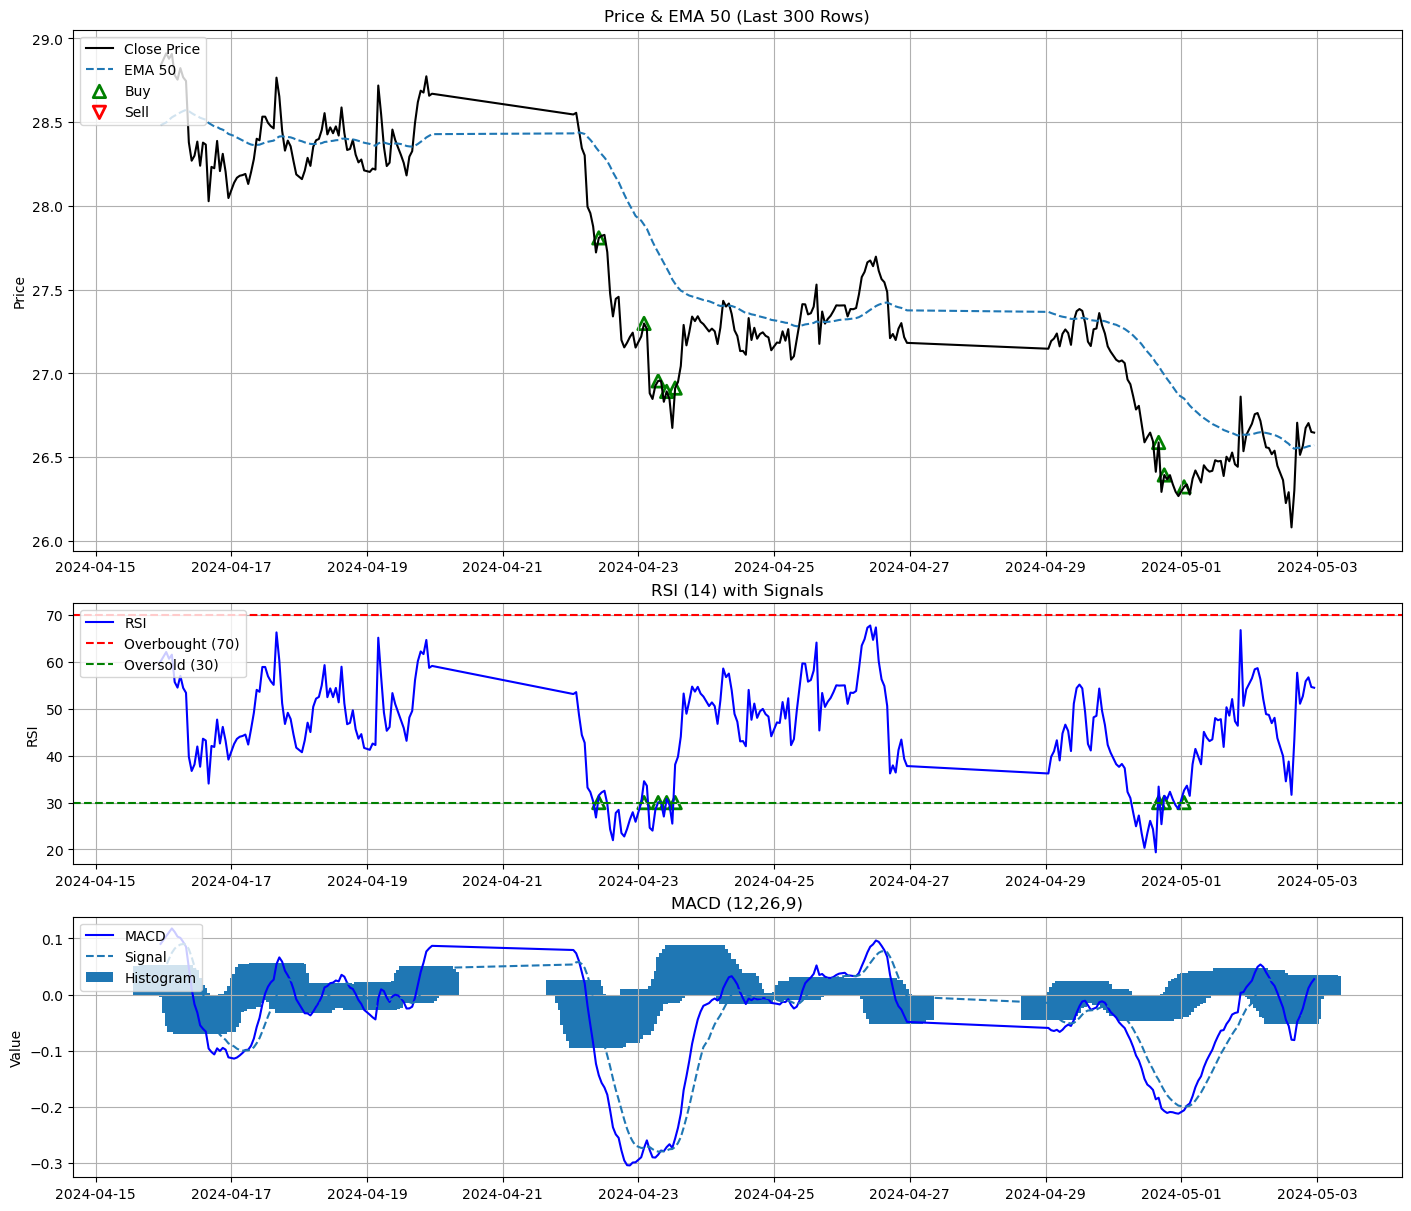

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import talib
import numpy as np

# === CONFIGURATION ===
RAW_CSV_PATH   = "../datasets/XAGUSD-H1-rates.csv"   # Original OHLCV CSV
OUTPUT_CSV     = "forex_with_indicators.csv" # Output path
LOOKBACK_ROWS  = 300                         # Number of latest rows to plot
RSI_PERIOD     = 14                          # RSI period
EMA_PERIOD     = 50                          # EMA period
MACD_FAST      = 12                          # MACD fast EMA
MACD_SLOW      = 26                          # MACD slow EMA
MACD_SIGNAL    = 9                           # MACD signal line

# === 1- LOAD RAW DATA ===
df = pd.read_csv(RAW_CSV_PATH, sep='\t')  # adjust sep if comma‑separated
df['DATETIME'] = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
df.set_index('DATETIME', inplace=True)
df.drop(columns=['<DATE>', '<TIME>'], inplace=True)
for col in ['<OPEN>','<HIGH>','<LOW>','<CLOSE>']:
    df[col] = df[col].astype(float)

# === 2- CALCULATE INDICATORS & SAVE ===
# RSI
df['RSI'] = talib.RSI(df['<CLOSE>'], timeperiod=RSI_PERIOD)
# EMA
df[f'EMA_{EMA_PERIOD}'] = talib.EMA(df['<CLOSE>'], timeperiod=EMA_PERIOD)
# MACD
macd, macd_signal, macd_hist = talib.MACD(
    df['<CLOSE>'],
    fastperiod=MACD_FAST,
    slowperiod=MACD_SLOW,
    signalperiod=MACD_SIGNAL
)
df['MACD']        = macd
df['MACD_SIGNAL'] = macd_signal
df['MACD_HIST']   = macd_hist

df.to_csv(OUTPUT_CSV)
print(f"✅ Indicators added and saved to {OUTPUT_CSV}")

# === 3- RELOAD & TRIM ===
df = pd.read_csv(OUTPUT_CSV, parse_dates=['DATETIME'], index_col='DATETIME')
if LOOKBACK_ROWS > 0:
    df = df.tail(LOOKBACK_ROWS)

# === 4- SIGNAL DETECTION (RSI CROSSOVERS) ===
rsi       = df['RSI']
prev_rsi  = rsi.shift(1)
buy_mask  = (prev_rsi < 30) & (rsi >= 30)
sell_mask = (prev_rsi > 70) & (rsi <= 70)

buy_times  = df.index[buy_mask]
buy_prices = df['<CLOSE>'][buy_mask]
sell_times  = df.index[sell_mask]
sell_prices = df['<CLOSE>'][sell_mask]

# === 5- PLOTTING ===
fig = plt.figure(constrained_layout=True, figsize=(14, 12))
gs  = fig.add_gridspec(3, 1, height_ratios=[2, 1, 1])

# — Price + EMA + Signals —
ax0 = fig.add_subplot(gs[0, 0])
ax0.plot(df.index, df['<CLOSE>'], label='Close Price', color='black')
ax0.plot(df.index, df[f'EMA_{EMA_PERIOD}'], label=f'EMA {EMA_PERIOD}', linestyle='--')
ax0.scatter(buy_times,  buy_prices,  marker='^', s=80,
            edgecolors='green', facecolors='none', linewidths=2, label='Buy')
ax0.scatter(sell_times, sell_prices, marker='v', s=80,
            edgecolors='red',   facecolors='none', linewidths=2, label='Sell')
ax0.set_title(f'Price & EMA {EMA_PERIOD} (Last {LOOKBACK_ROWS} Rows)')
ax0.set_ylabel('Price')
ax0.legend(loc='upper left')
ax0.grid(True)

# — RSI + Signals —
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)
ax1.plot(df.index, rsi, label='RSI', color='blue')
ax1.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax1.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax1.scatter(buy_times,  np.repeat(30, buy_times.size),  marker='^', s=80,
            edgecolors='green', facecolors='none', linewidths=2)
ax1.scatter(sell_times, np.repeat(70, sell_times.size), marker='v', s=80,
            edgecolors='red',   facecolors='none', linewidths=2)
ax1.set_title('RSI (14) with Signals')
ax1.set_ylabel('RSI')
ax1.legend(loc='upper left')
ax1.grid(True)

# — MACD —
ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)
ax2.plot(df.index, df['MACD'],        label='MACD', color='blue')
ax2.plot(df.index, df['MACD_SIGNAL'], label='Signal', linestyle='--')
ax2.bar(df.index, df['MACD_HIST'], label='Histogram')
ax2.set_title(f'MACD ({MACD_FAST},{MACD_SLOW},{MACD_SIGNAL})')
ax2.set_ylabel('Value')
ax2.legend(loc='upper left')
ax2.grid(True)

plt.show()
